# **----- Import Libraries -----**

In [1]:
import pandas as pd

# import the libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# import the libraries for saving the model, vectorizer, scaler
import pickle, json

# import train test split
from sklearn.model_selection import train_test_split

# import the vectorizers, scaler, smote
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# import the model including logistic regression, decision tree, bagged decision tree, random forest, ada boost, gradient boost, xgboost, svm 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# import the metrics including accuracy score, precision score, recall score, f1 score, roc auc score, confusion matrix as well as classification report, roc curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve



# **----- Import Data -----**

In [2]:
#import the file "df_pantip_posts_suicide_labeled_processed.csv" from output folder
df_pantip_posts_suicide_labeled_processed = pd.read_csv('../output - final/df_pantip_posts_suicide_labeled_processed.csv')

# **----- Define X,y and Do Train-test Split -----**

In [3]:
# list columns
print(df_pantip_posts_suicide_labeled_processed.columns)

Index(['Unnamed: 0', 'index', 'title', 'url', 'label', 'tags', 'text',
       'profile', 'time', 'sub_label', 'all_text', 'tokenized_text',
       'day_week', 'day_month', 'month_year', 'year', 'time_day', 'title_len',
       'text_len', 'title_emoji', 'text_emoji'],
      dtype='object')


In [4]:
df_pantip_posts_suicide_labeled_processed.drop(columns=['Unnamed: 0'], inplace = True)

In [5]:
# check NaN
df_pantip_posts_suicide_labeled_processed.isnull().sum()

index             0
title             0
url               0
label             0
tags              0
text              0
profile           0
time              0
sub_label         0
all_text          0
tokenized_text    0
day_week          0
day_month         0
month_year        0
year              0
time_day          0
title_len         0
text_len          0
title_emoji       0
text_emoji        0
dtype: int64

In [6]:
# Filter the DataFrame to include only rows where 'sub_label' is 11 or 12
filtered_df = df_pantip_posts_suicide_labeled_processed[df_pantip_posts_suicide_labeled_processed['sub_label'].isin([11, 12])]

# Define 'X' to contain only the 'sub_label' column of the filtered DataFrame
y = filtered_df[['sub_label']]

# Define 'y' to include the specified columns of the filtered DataFrame
X = filtered_df.drop(columns=['index', 'title', 'url', 'label', 'text','all_text',
       'profile', 'time'])

# Print the columns of 'X' and 'y'
print("Columns in X:", X.columns)
print('shape in X:', X.shape)
print("Columns in y:", y.columns)
print('shape in y', y.shape)
print(y.value_counts())

Columns in X: Index(['tags', 'sub_label', 'tokenized_text', 'day_week', 'day_month',
       'month_year', 'year', 'time_day', 'title_len', 'text_len',
       'title_emoji', 'text_emoji'],
      dtype='object')
shape in X: (1261, 12)
Columns in y: Index(['sub_label'], dtype='object')
shape in y (1261, 1)
sub_label
11           779
12           482
Name: count, dtype: int64


In [7]:
# transform value in column 'sub_label'
# 11 = 1
# 12 = 0

#create mapping value
mapping_value = {11:1, 12:0}

#map value on column 'sub_label'(
y['sub_label'] = y['sub_label'].map(mapping_value)

#show result 
y['sub_label'].value_counts()

C:\Users\HP\AppData\Local\Temp\ipykernel_21524\3308730798.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['sub_label'] = y['sub_label'].map(mapping_value)


sub_label
1    779
0    482
Name: count, dtype: int64

In [8]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42, stratify= y)

# **----- Feature Engineering -----**

In [9]:
#Step 1: One-Hot Encoding for Categorical Data

cols = ['day_week', 'day_month', 'month_year', 'year', 'time_day', 'title_emoji', 'text_emoji']
X_train_categorical = pd.get_dummies(X_train[cols], columns=cols, drop_first=True, dtype=int)
X_test_categorical = pd.get_dummies(X_test[cols], columns=cols, drop_first=True, dtype=int)

print(X_train_categorical.columns)
print(type(X_train_categorical))
print(X_train_categorical.shape)

Index(['day_week_Monday', 'day_week_Saturday', 'day_week_Sunday',
       'day_week_Thursday', 'day_week_Tuesday', 'day_week_Wednesday',
       'day_month_2', 'day_month_3', 'day_month_4', 'day_month_5',
       'day_month_6', 'day_month_7', 'day_month_8', 'day_month_9',
       'day_month_10', 'day_month_11', 'day_month_12', 'day_month_13',
       'day_month_14', 'day_month_15', 'day_month_16', 'day_month_17',
       'day_month_18', 'day_month_19', 'day_month_20', 'day_month_21',
       'day_month_22', 'day_month_23', 'day_month_24', 'day_month_25',
       'day_month_26', 'day_month_27', 'day_month_28', 'day_month_29',
       'day_month_30', 'day_month_31', 'month_year_August',
       'month_year_December', 'month_year_February', 'month_year_January',
       'month_year_July', 'month_year_June', 'month_year_March',
       'month_year_May', 'month_year_November', 'month_year_October',
       'month_year_September', 'year_2017', 'year_2018', 'year_2019',
       'year_2020', 'year_2021', 'y

In [10]:
#Step 2: Vectorization of 'tokenized_text'

vectorizer = TfidfVectorizer()
X_train_text = vectorizer.fit_transform(X_train['tokenized_text'])
X_test_text = vectorizer.transform(X_test['tokenized_text'])

print(type(X_train_text))
print(X_train_text.shape)

print(type(X_test_text))
print(X_test_text.shape)

<class 'scipy.sparse._csr.csr_matrix'>
(1008, 4678)
<class 'scipy.sparse._csr.csr_matrix'>
(253, 4678)


In [11]:
# Step 3: Scaling of Numerical Data

scaler = StandardScaler()
X_train_numerical = scaler.fit_transform(X_train[['text_len']])
X_test_numerical = scaler.transform(X_test[['text_len']])

print(type(X_train_numerical))
X_train_numerical.shape

<class 'numpy.ndarray'>


(1008, 1)

In [12]:
# Step 4: Concatenate All Features for Training Data

X_train_all = pd.concat([
    pd.DataFrame(X_train_numerical, columns=['text_len'], index=X_train.index),
    pd.DataFrame(X_train_text.todense(), columns=vectorizer.get_feature_names_out(), index=X_train.index),
    X_train_categorical
], axis=1)

print(X_train_all.shape)


(1008, 4742)


In [13]:
# Step 4: Concatenate All Features for Test Data
X_test_all = pd.concat([
    pd.DataFrame(X_test_numerical, columns=['text_len'], index=X_test.index),
    pd.DataFrame(X_test_text.todense(), columns=vectorizer.get_feature_names_out(), index=X_test.index),
    X_test_categorical
], axis=1)

print(X_test_all.shape)

(253, 4742)


In [14]:
# Step 5: smote X_train and y_train
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train_all, y_train)

print(X_train_sm.shape)


(1246, 4742)


In [15]:
# Step 6: Checking and Renaming Duplicate Features

# Function to rename duplicate columns by adding a suffix
def rename_duplicates(df):
    cols = pd.Series(df.columns)
    for dup in cols[cols.duplicated()].unique():
        cols[cols[cols == dup].index.values.tolist()] = [dup + '_' + str(i) if i != 0 else dup for i in range(sum(cols == dup))]
    df.columns = cols
    return df

# Apply it to your training data
rename_duplicates(X_train_sm)

# If you're transforming your test data similarly, apply it there too
rename_duplicates(X_test_all)

# check the shape of X_train_sm and X_test_all
print(X_train_sm.shape)
print(X_test_all.shape)

(1246, 4742)
(253, 4742)


In [16]:
X_train_sm.columns.isna().sum()

0

In [17]:
# Save X_train_sm column to the list of X_train_sm columns so we can use this list to match with X_sm of youtube data and use the same model to predict
X_train_sm_columns = X_train_sm.columns.tolist()

with open('../model/X_train_sm_sublabel_columns.json', 'w') as f:
    json.dump(X_train_sm_columns, f)

# **----- Do the  modeling & evaluating -----**

## Logistic Regression Modeling & Coefficient Analysis

In [18]:
# Run Logistic Regression Model to test compute time
lr = LogisticRegression(random_state=42, class_weight={1:1, 0:1})
lr.fit(X_train_sm, y_train_sm)
y_pred_lr = lr.predict(X_test_all)
y_pred_lr_proba = lr.predict_proba(X_test_all)[:,1]


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [19]:
# Set threshold for Logistic Regression

def get_pred_by_proba(proba, threshold=0.5):
    return [1 if p >= threshold else 0 for p in proba]


y_pred_lr = get_pred_by_proba(y_pred_lr_proba, threshold=0.2)

In [20]:
# evaluate the model both test and train model comparison for Logistic Regression
print('Logistic Regression')
print('Accuracy score: ', accuracy_score(y_test, y_pred_lr))
print('Precision score: ', precision_score(y_test, y_pred_lr))
print('Recall score: ', recall_score(y_test, y_pred_lr))
print('F1 score: ', f1_score(y_test, y_pred_lr))
print('ROC AUC score: ', roc_auc_score(y_test, y_pred_lr))
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred_lr))
print('Classification Report: \n', classification_report(y_test, y_pred_lr))


Logistic Regression
Accuracy score:  0.6521739130434783
Precision score:  0.639344262295082
Recall score:  1.0
F1 score:  0.78
ROC AUC score:  0.5463917525773196
Confusion Matrix: 
 [[  9  88]
 [  0 156]]
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.09      0.17        97
           1       0.64      1.00      0.78       156

    accuracy                           0.65       253
   macro avg       0.82      0.55      0.47       253
weighted avg       0.78      0.65      0.55       253



In [21]:
# save classification report to csv file
report = classification_report(y_test, y_pred_lr, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv('../result/pantip_model_simplifeid_sublabel_lr_classification_report.csv', index=False)

In [22]:
# save model to pickle file
pickle.dump(lr, open('../model/pantip_post_model_train_simplified_sublabel_lr.pkl', 'wb'))

# save vectorizer to pickle file
pickle.dump(vectorizer, open('../model/pantip_post_model_train_simplified_sublabel_vectorizer.pkl', 'wb'))

# save scaler to pickle file
pickle.dump(scaler, open('../model/pantip_post_model_train_simplified_sublabel_scaler.pkl', 'wb'))


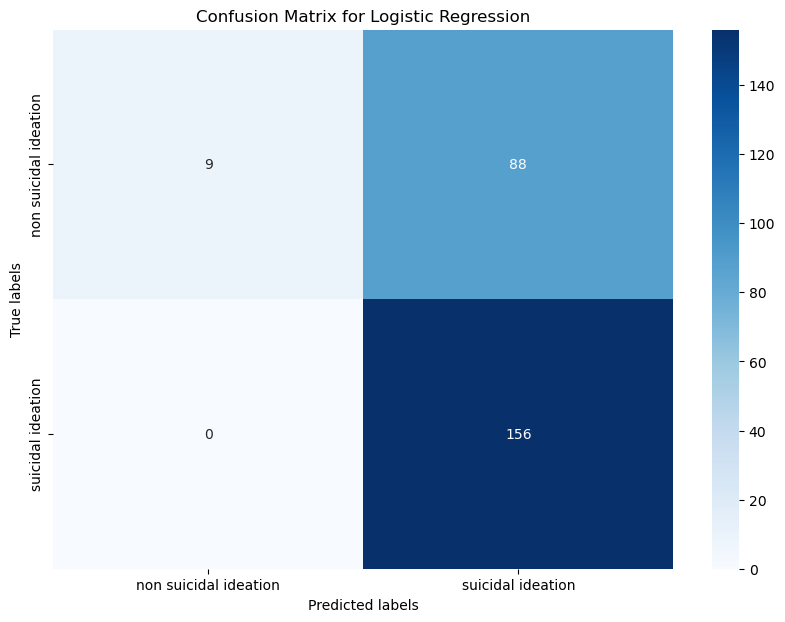

In [23]:
# use the confusion matrix display function from library to display the confusion matrix chart for Logistic Regression; assuming label 1 is suicidal ideation and 0 is non suicidal ideation
cm = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Logistic Regression')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.xticks([0.5, 1.5], ['non suicidal ideation', 'suicidal ideation'])
plt.yticks([0.5, 1.5], ['non suicidal ideation', 'suicidal ideation'])
plt.savefig('../result/pantip_model_simplified_label_lr_confusion_matrix.png')
plt.show()


In [24]:
# create the coefficients dataframe and sorting the values from highest to lowest
coef_df = pd.DataFrame(lr.coef_.T, index=X_train_sm.columns, columns=['coef'])
coef_df['coef_abs'] = coef_df['coef'].abs()
coef_df = coef_df.sort_values(by='coef_abs', ascending=False)           
coef_df.head(20)

,coef,coef_abs
วตาย,6.790650,6.790650
าต,6.645438,6.645438
จบช,1.828734,1.828734
ดส,1.712407,1.712407
ทำร,1.642035,1.642035
โลก,-1.578306,1.578306
หาย,-1.574898,1.574898
ตาย,-1.498501,1.498501
month_year_August,1.385314,1.385314
วเอง,1.321789,1.321789


## Decision Tree Modeling 

In [25]:
# Run Decision Tree Model to test compute time
dt = DecisionTreeClassifier(random_state=42, class_weight={0:1, 1:1})
dt.fit(X_train_sm, y_train_sm)
y_pred_dt = dt.predict(X_test_all)
y_pred_dt_proba = dt.predict_proba(X_test_all)[:,1]

In [26]:
# Set threshold for Decision Tree

def get_pred_by_proba(proba, threshold=0.5):
    return [1 if p >= threshold else 0 for p in proba]

y_pred_dt = get_pred_by_proba(y_pred_dt_proba, threshold=0.4)

In [27]:
# evaluate the model both test and train model comparison for Decision Tree

print('Decision Tree')
print('Accuracy score: ', accuracy_score(y_test, y_pred_dt))
print('Precision score: ', precision_score(y_test, y_pred_dt))
print('Recall score: ', recall_score(y_test, y_pred_dt))
print('F1 score: ', f1_score(y_test, y_pred_dt))
print('ROC AUC score: ', roc_auc_score(y_test, y_pred_dt))
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred_dt))
print('Classification Report: \n', classification_report(y_test, y_pred_dt))


Decision Tree
Accuracy score:  0.8102766798418972
Precision score:  0.8375
Recall score:  0.8589743589743589
F1 score:  0.8481012658227848
ROC AUC score:  0.7954665609304785
Confusion Matrix: 
 [[ 71  26]
 [ 22 134]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.76      0.73      0.75        97
           1       0.84      0.86      0.85       156

    accuracy                           0.81       253
   macro avg       0.80      0.80      0.80       253
weighted avg       0.81      0.81      0.81       253



In [28]:
# save classification report to csv file
report = classification_report(y_test, y_pred_dt, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv('../result/pantip_model_simplifeid_sublabel_dt_classification_report.csv', index=False)

In [29]:
# save model to pickle file
pickle.dump(dt, open('../model/pantip_post_model_train_simplified_sublabel_dt', 'wb'))

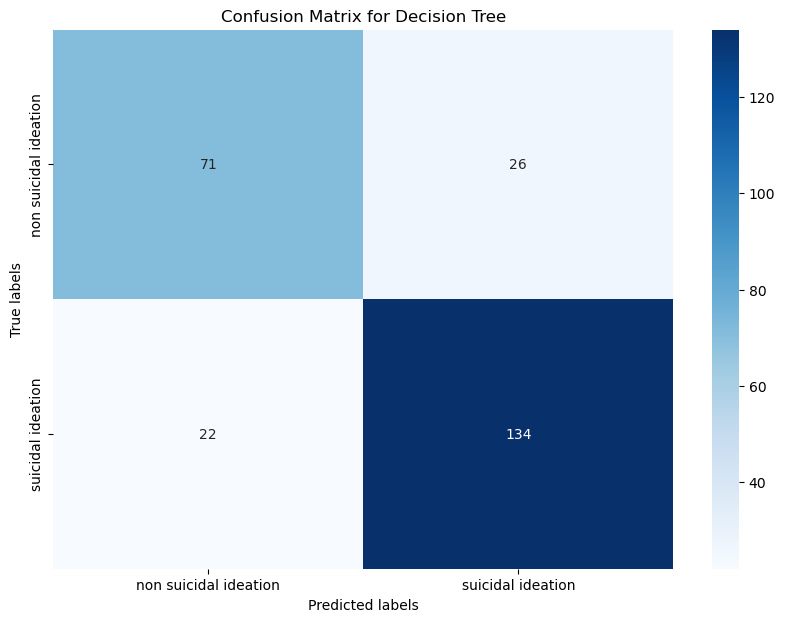

In [30]:
# use the confusion matrix display function from library to display the confusion matrix chart for Logistic Regression; assuming label 1 is suicidal ideation and 0 is non suicidal ideation
cm = confusion_matrix(y_test, y_pred_dt)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Decision Tree')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.xticks([0.5, 1.5], ['non suicidal ideation', 'suicidal ideation'])
plt.yticks([0.5, 1.5], ['non suicidal ideation', 'suicidal ideation'])
plt.savefig('../result/pantip_model_simplified_label_dt_confusion_matrix.png')
plt.show()